<a href="https://colab.research.google.com/github/NikNord174/GAN_sandbox/blob/main/GAN_Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Реализация простого GAN для генерации изображений одежды из датасета Fasion-MNIST

In [3]:
import torch
import torchvision
import numpy as np
from torchvision.transforms import Compose, ToTensor, Normalize
from torchvision import datasets
from torch import nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.tensorboard import SummaryWriter
from torchvision.utils import save_image

In [2]:
!mkdir diff-run
!mkdir diff-run/images
writer = SummaryWriter('diff-run/py-gan')

In [3]:
n_epochs=200    #number of epochs of training
batch_size=128  #size of the batches
lr=2e-4         #adam: learning rate
b1=0.5          #adam: decay of first order momentum of gradient
b2=0.999        #adam: decay of first order momentum of gradient
latent_dim=100  #dimension of the latent space (generator's input)
img_size=28     #image size
channels=1      #image channels
image_shape=(1,28,28)
image_dim=int(np.prod(image_shape))

In [4]:
train_transform=torchvision.transforms.Compose([
                                                ToTensor(),
                                                Normalize(mean=(0.5), std=(0.5))
                                                ])

train_dataset=datasets.FashionMNIST(root='./data/', train=True, transform=train_transform, download=True)
train_loader=torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [5]:
#Generator Model Definition

class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()

    self.model=nn.Sequential(
        nn.Linear(latent_dim,128),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Linear(128,256),
        nn.BatchNorm1d(256,0.8),
        nn.LeakyReLU(0.2,inplace=True),
        nn.Linear(256,512),
        nn.BatchNorm1d(512,0.8),
        nn.LeakyReLU(0.2,inplace=True),
        nn.Linear(512,1024),
        nn.BatchNorm1d(1024,0.8),
        nn.LeakyReLU(0.2,inplace=True),
        nn.Linear(1024,image_dim),
        nn.Tanh()
        )
  def forward(self, noise_vector):
    image=self.model(noise_vector)
    image=image.view(image.size(0), *image_shape)
    return image

In [13]:
for i, (real_images,_) in enumerate(train_loader):
  noise_vector=torch.randn(real_images.size(0),latent_dim)
  im=Generator().forward(noise_vector)
  print(im.shape)
  print((im.view(im.size(0),*image_shape)).shape)
  print((im.view(im.size(0),-1,28)).shape)
  break

torch.Size([128, 784])
torch.Size([128, 1, 28, 28])
torch.Size([128, 28, 28])


In [6]:
#Discriminator Model Definition

class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()

    self.model=nn.Sequential(
        nn.Linear(image_dim,512),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Linear(512,256),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Linear(256,1),
        nn.Sigmoid()
        )
  
  def forward(self, image):
    image_flattened=image.view(image.size(0),-1)
    result=self.model(image_flattened)
    return result

In [7]:
#Loss Function
adversarial_loss=nn.BCELoss()

#Optimization
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
generator = Generator().to(device)
discriminator = Discriminator().to(device)

G_optimizer=optim.Adam(generator.parameters(), lr=lr, betas=(b1,b2))
D_optimizer=optim.Adam(discriminator.parameters(), lr=lr, betas=(b1,b2))

In [11]:
D_loss_plot, G_loss_plot = [], []
for epoch in range(1, n_epochs+1):
  D_loss_list, G_loss_list=[],[]

  for index, (real_images, _) in enumerate(train_loader):
    D_optimizer.zero_grad()
    real_images=real_images.to(device)
    real_target=torch.ones(real_images.size(0),1).to(device)
    fake_target=torch.zeros(real_images.size(0),1).to(device)

    #real part of D Loss
    D_real_loss=adversarial_loss(discriminator(real_images),real_target)

    noise_vector=torch.randn(real_images.size(0),latent_dim).to(device)
    noise_vector=noise_vector.to(device)
    generated_image=generator(noise_vector)

    #fake part D Loss
    D_fake_loss=adversarial_loss(discriminator(generated_image),fake_target)

    D_total_loss=(D_real_loss+D_fake_loss)/2
    D_loss_list.append(D_total_loss)
    D_total_loss.backward(retain_graph=True)
    D_optimizer.step()

    #training G on D's output
    G_optimizer.zero_grad()
    geerated_image=generator(noise_vector)
    G_loss=adversarial_loss(discriminator(generated_image),real_target)
    G_loss_list.append(G_loss)
    G_loss.backward()
    G_optimizer.step()

    d = generated_image.data

    writer.add_scalar('Discriminator Loss',
                            D_total_loss,
                            epoch * len(train_loader) + index)

    writer.add_scalar('Generator Loss',
                            G_loss,
                            epoch * len(train_loader) + index)


  print('Epoch: [%d/%d]: D_loss: %.3f, G_loss: %.3f' % (
            (epoch), n_epochs, torch.mean(torch.FloatTensor(D_loss_list)),\
             torch.mean(torch.FloatTensor(G_loss_list))))

  D_loss_plot.append(torch.mean(torch.FloatTensor(D_loss_list)))
  G_loss_plot.append(torch.mean(torch.FloatTensor(G_loss_list)))
  save_image(generated_image.data[:90], '/content/diff-run/images/sample_%d'%epoch + '.png', nrow=10, normalize=True)

Epoch: [1/200]: D_loss: 0.563, G_loss: 1.202
Epoch: [2/200]: D_loss: 0.569, G_loss: 1.251
Epoch: [3/200]: D_loss: 0.557, G_loss: 1.309
Epoch: [4/200]: D_loss: 0.549, G_loss: 1.369
Epoch: [5/200]: D_loss: 0.575, G_loss: 1.283
Epoch: [6/200]: D_loss: 0.594, G_loss: 1.198
Epoch: [7/200]: D_loss: 0.602, G_loss: 1.174
Epoch: [8/200]: D_loss: 0.602, G_loss: 1.164
Epoch: [9/200]: D_loss: 0.603, G_loss: 1.168
Epoch: [10/200]: D_loss: 0.596, G_loss: 1.158
Epoch: [11/200]: D_loss: 0.597, G_loss: 1.190
Epoch: [12/200]: D_loss: 0.595, G_loss: 1.148
Epoch: [13/200]: D_loss: 0.594, G_loss: 1.172
Epoch: [14/200]: D_loss: 0.605, G_loss: 1.109
Epoch: [15/200]: D_loss: 0.606, G_loss: 1.118
Epoch: [16/200]: D_loss: 0.609, G_loss: 1.114
Epoch: [17/200]: D_loss: 0.603, G_loss: 1.107
Epoch: [18/200]: D_loss: 0.604, G_loss: 1.108
Epoch: [19/200]: D_loss: 0.604, G_loss: 1.129
Epoch: [20/200]: D_loss: 0.605, G_loss: 1.111
Epoch: [21/200]: D_loss: 0.602, G_loss: 1.092
Epoch: [22/200]: D_loss: 0.604, G_loss: 1.1

In [30]:
D_losses=[]
G_losses=[]
for i,j in zip(D_loss_plot,G_loss_plot):
  D_losses.append(i.item())
  G_losses.append(j.item())

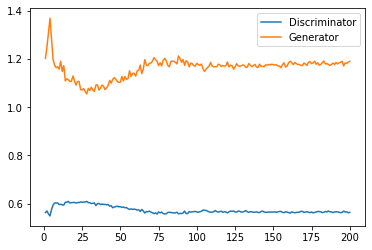

In [35]:
import matplotlib.pyplot as plt
plt.plot(range(1, n_epochs+1),D_losses,label='Discriminator')
plt.plot(range(1, n_epochs+1), G_losses,label='Generator')
plt.legend()
plt.savefig('/content/diff-run/images/losses.png')